# Library needed

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

np.random.seed(42)

# Data Preprocessing

In [6]:
college = pd.read_csv("College.csv")

In [7]:
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [8]:
college.isnull().any(axis=1).sum()

0

In [9]:
college["Private"] = college["Private"].map({"Yes": 1, "No": 0})

In [10]:
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [11]:
college = college.drop("Unnamed: 0", axis=1)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [12]:
college_scaled = StandardScaler().fit_transform(college)
college_scaled

array([[ 6.12553050e-01, -3.46881819e-01, -3.21205453e-01, ...,
        -8.67574189e-01, -5.01910084e-01, -3.18251941e-01],
       [ 6.12553050e-01, -2.10884040e-01, -3.87029908e-02, ...,
        -5.44572203e-01,  1.66109850e-01, -5.51261842e-01],
       [ 6.12553050e-01, -4.06865631e-01, -3.76317928e-01, ...,
         5.85934748e-01, -1.77289956e-01, -6.67766793e-01],
       ...,
       [ 6.12553050e-01, -2.33895071e-01, -4.23771558e-02, ...,
        -2.21570217e-01, -2.56241250e-01, -9.59029170e-01],
       [ 6.12553050e-01,  1.99171118e+00,  1.77256262e-01, ...,
         2.12019418e+00,  5.88797079e+00,  1.95359460e+00],
       [ 6.12553050e-01, -3.26765760e-03, -6.68715889e-02, ...,
         4.24433755e-01, -9.87115613e-01,  1.95359460e+00]])

# Implement the KMeans clustering algorithm

In [13]:
class myKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, K, tol, iter):
        self.K = K
        self.tol = tol
        self.iter = iter

    def kmeans_init_centroids(self, X, k):
        # randomly pick k rows of X ans initial centroids
        return X[np.random.choice(X.shape[0], k)]

    def kmeans_assign_labels(self, X, centroids):
        # calculate pairwise distances btw data and centroids and return index of the closest centroid
        return np.argmin(cdist(X, centroids), axis=1)

    def kmeans_update_centroids(self, X, labels, K):
        centroids = np.zeros((K, X.shape[1]))
        for k in range(K):
            # collect all points assigned to the k-th cluster
            Xk = X[labels == k, :]
            # take average
            centroids[k, :] = np.mean(Xk, axis=0)
        return centroids

    def has_converged(self, list_of_centroids, new_list_of_centroids, tol):
        # return True if two sets of centroids as the same
        return np.all(np.linalg.norm(list_of_centroids[-1] - new_list_of_centroids, axis=1) < tol)

    def kmeans(self, X, K, tol, iter):
        list_of_centroids = [self.kmeans_init_centroids(X, K)]
        labels = []

        while True:
            labels.append(self.kmeans_assign_labels(X, list_of_centroids[-1]))
            new_list_of_centroids = self.kmeans_update_centroids(X, labels[-1], K)
            if self.has_converged(list_of_centroids[-1], new_list_of_centroids, tol) or len(list_of_centroids) > iter:
                break
            list_of_centroids.append(new_list_of_centroids)

        return (list_of_centroids, labels)

    def distance_to_centroid(self, X, K, centroids, labels):
        dis = []
        for k in range(K):
            d = sum([np.linalg.norm(X[labels == k, :][i] - centroids[k])**2 for i in range(X[labels == k, :].shape[0])])
            dis.append(d)
        return sum(dis)

    def fit(self, X, y=None):
        X = check_array(X)
        (centroids, labels) = self.kmeans(X, self.K, self.tol, self.iter)
        self.cluster_centers_ = centroids[-1]
        self.labels_ = labels[-1]
        self.n_iter_ = len(centroids)
        self.inertia_ = self.distance_to_centroid(X, self.K, self.cluster_centers_, self.labels_)

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.distance_to_centroid(X, self.K, self.cluster_centers_, self.labels_)
    
    def predict(self, X):
        check_is_fitted(self, 'cluster_centers_')
        X = check_array(X)
        return self.kmeans_assign_labels(X, self.cluster_centers_)

# Testing and Validation

In [14]:
cluster_college = myKMeans(K=3, tol=1e-4, iter=10000)
cluster_college.fit(college_scaled)
cluster_college.cluster_centers_

array([[-1.48058999,  1.39147649,  1.51607655,  1.68174177, -0.0133445 ,
         0.18844263,  1.77076911,  1.28244285, -0.69658   , -0.33426701,
         0.20019858,  0.72871138,  0.59172499,  0.56292573,  0.72068778,
        -0.6435371 , -0.22821005, -0.46016023],
       [ 0.14648898, -0.45244717, -0.44253351, -0.42557875, -0.52698391,
        -0.57965776, -0.41295424, -0.20278755, -0.42848549, -0.35634589,
        -0.10859249, -0.03617554, -0.67036103, -0.66050233,  0.15485472,
        -0.28617061, -0.43311223, -0.32061153],
       [ 0.5584551 , -0.02550096, -0.1077809 , -0.22316485,  0.84310627,
         0.81888331, -0.29074444, -0.36330851,  1.05179481,  0.74383189,
         0.06533182, -0.33184448,  0.74736218,  0.74710561, -0.63059876,
         0.79770211,  0.80896092,  0.75438902]])

In [15]:
cluster_college.inertia_

8739.886691181344

In [16]:
kmeans_sklearn = KMeans(n_clusters=3, random_state=42)
kmeans_sklearn.fit(college_scaled)
kmeans_sklearn.cluster_centers_

array([[ 0.07396429, -0.42945619, -0.42240272, -0.40333553, -0.53948459,
        -0.59016143, -0.38279228, -0.18191562, -0.47283161, -0.38981263,
        -0.10941073,  0.00540659, -0.66025879, -0.65483575,  0.18977194,
        -0.32740231, -0.44453258, -0.36326522],
       [-1.48158295,  1.51320731,  1.65266849,  1.83917432,  0.06126816,
         0.26672235,  1.91613111,  1.38292533, -0.66507767, -0.30196116,
         0.21526306,  0.74585005,  0.622841  ,  0.59079217,  0.71403532,
        -0.62939415, -0.1958458 , -0.41909236],
       [ 0.56113935, -0.03819473, -0.11219876, -0.22572853,  0.78757629,
         0.77085483, -0.29173229, -0.35316615,  1.01673878,  0.72633275,
         0.06759673, -0.34693575,  0.71505498,  0.72141484, -0.61114462,
         0.78072221,  0.7608418 ,  0.73940846]])

In [17]:
kmeans_sklearn.inertia_

8740.173751386177

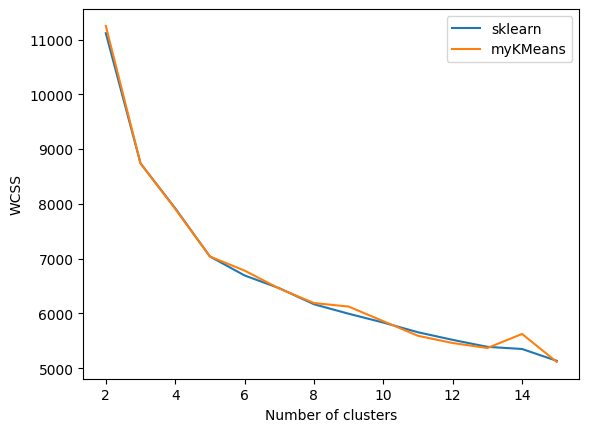

In [18]:
wcss1 = []
wcss2 = []
for i in range(2, 16):
    model_1 = kmeans_sklearn = KMeans(n_clusters=i, random_state=42)
    model_2 = myKMeans(K=i, tol=1e-4, iter=10000)
    model_1.fit(college_scaled)
    model_2.fit(college_scaled)
    wcss1.append(model_1.inertia_)
    wcss2.append(model_2.inertia_)

plt.plot(range(2, 16), wcss1, label="sklearn")
plt.plot(range(2, 16), wcss2, label="myKMeans")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.legend()
plt.show()

# Analysis and Interpretation

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
college_pca = pca.fit_transform(college_scaled)
centroids_pca = pca.transform(cluster_college.cluster_centers_)
centroids_pca_sklearn = pca.transform(kmeans_sklearn.cluster_centers_)

Text(0.5, 1.0, 'My KMeans')

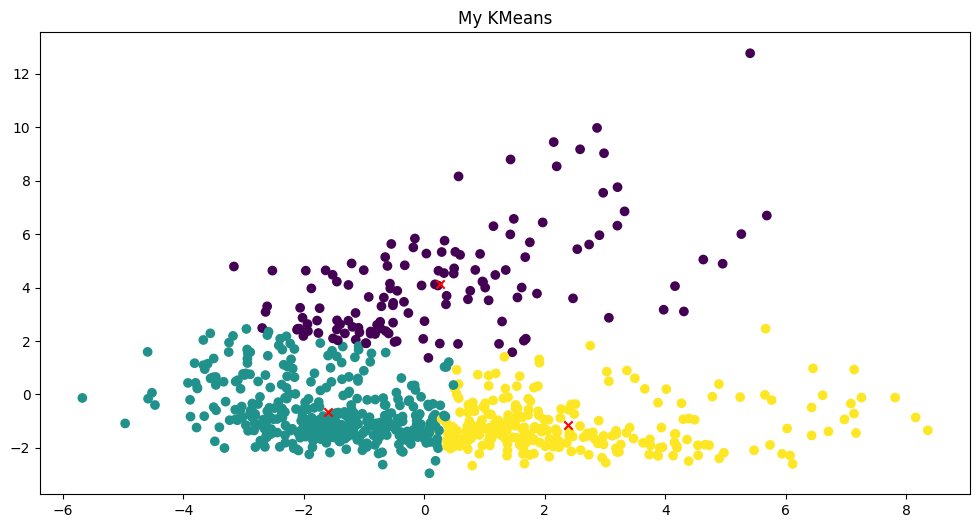

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(college_pca[:, 0], college_pca[:, 1], c=cluster_college.labels_[-1], cmap='viridis')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x')
plt.title("My KMeans")

Text(0.5, 1.0, 'KMeans Sklearn')

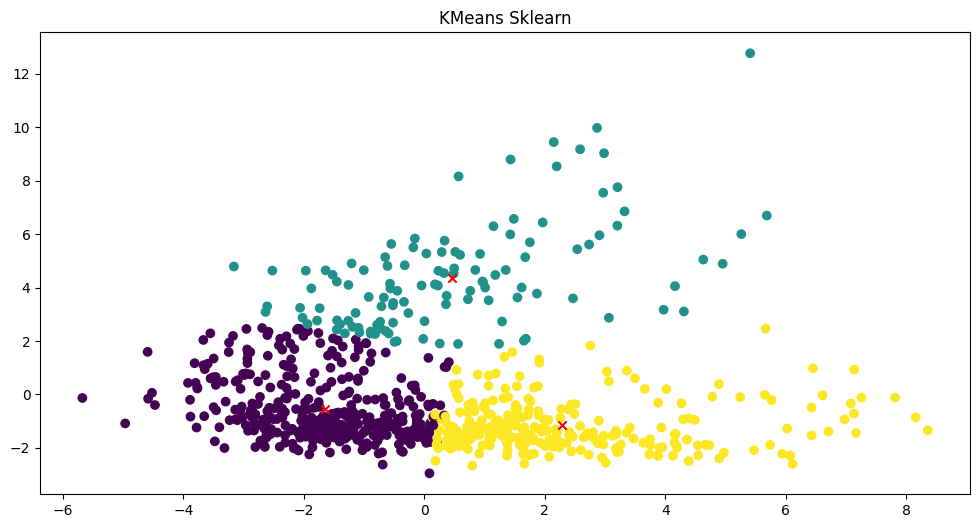

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(college_pca[:, 0], college_pca[:, 1], c=kmeans_sklearn.labels_, cmap='viridis')
plt.scatter(centroids_pca_sklearn[:, 0], centroids_pca_sklearn[:, 1], c='red', marker='x')
plt.title("KMeans Sklearn")